# Ejercicios 

In [ ]:
import numpy as np

---
## Convoluciones de arrays

:::{exercise}
:label: chapther2-convolution

Dadas dos funciones de variable real $f$ y $g$, definimos la [**convolución**](https://en.wikipedia.org/wiki/Convolution) de $f$ y $g$ como

$$
(f*g)(x) = \int_\mathbb{R} f(t)g(x - t)dt.
$$

La versión discreta de la anterior definición puede ser la siguiente. Datos $f=(f_0, \dots, f_{n-1})$ y $g=(g_0, \dots, g_{m-1})$ dos vectores (representados por arrays unidimensionales) de tamaño $n$ y $m$, respectivamente, definimos el array `conv` de dimensión `n + m - 1` cuya componente $k$ vale 

$$
\sum_{i + m -1 = k + j}f_ig_j
$$

para $0 \leq k \leq n + m - 1$. 

Crea una función `conv` que tome como inputs dos arrays y devuelva la convolución de ambos. Por ejemplo 

```
arr1 = np.arange(10)
arr2 = np.arange(5) 
conv(arr1, arr2)
>>> [ 0  4 11 20 30 40 50 60 70 80 50 26  9  0]
```

:::

:::{solution} chapther2-convolution
:class: dropdown

Una primera solución iterando sobre todos las posibles combinaciones de $i$ y $j$ para cada $k$
```
from itertools import product

def conv(f, g):
    n = f.shape[0]
    m = g.shape[0]
    conv_dim = n + m - 1
    arr_conv = np.zeros(conv_dim, dtype=f.dtype)
    for k in range(conv_dim):
        my_gen = (
            f[i]*g[j] for i, j in product(range(n), range(m)) \
                if i + m - 1 == j + k
        )
        arr_conv[k] = sum(my_gen)
    return arr_conv
```

Otra solución más directa considerando la matrix *producto exterior* de $f$ y $g$ y sumando las diagonales 

```
def conv2(f, g):
    i = f.shape[0]
    j = g.shape[0]
    outer_mat = np.outer(f, g).T
    c = np.array([np.trace(outer_mat, offset=k) for k in range(-j + 1, i)])
    return c
```

:::


---
## Procesando imágenes con numpy

:::{exercise}
:label: chapter2-images

Una de las posibles técnicas que existen para comprimir una imagen es utilizar [la descomposición SVD (Singular Value Decomposition)](https://en.wikipedia.org/wiki/Singular_value_decomposition) que nos permite expresar una matrix $A$ de dimensiones $n\times m$ como un producto

$$ 
A = U \Sigma V^t
$$

donde $U$ y $V$ son cuadradas de dimensiones $n$ y $m$ respectivamente y $\Sigma$ es diagonal y está formada por los [valores singulares](https://en.wikipedia.org/wiki/Singular_value) de $A$ ordenados de mayor a menor (siempre son números reales y positivos). 

Recuerda que una imagen no es más que un conjunto de 3 matrices, cada una representando la intensidad de la grilla de píxeles para cada color (rojo, verde y azul). Una forma de comprimir una imagen consiste en quedarse con los $k$ primeros valores singulares para cada color e intercambiar $k$ por una se las dimensiones que representan el alto o el ancho de la imagen. 

Crea una función `aproxima_img` que tome un array de dimensión $(3, h, w)$ y devuelva otra imagen aproximada de dimensión $(3, h, w)$ utilizando los k primeros valores singulares. Para ello, 
1. Utiliza la función `scipy.misc.face` para generar una imagen de prueba, o también puedes importar una utilizando `im = cv2.imread("img.jpg")`. Puedes visualizar imágenes con este formato a través del la función `imshow` de `matplotlib.pyplot` (a veces hay que cambiar de orden los canales).
2. Utiliza la función `svd` de `np.linalg` para realizar la descomposición SVD. Mucho cuidado con las dimensiones que espera la función. 
3. Otras funciones que pueden ser útiles para el ejercicio: `np.transpose`, `np.zeros`, `np.fill_diagonal`, `np.clip`.

:::

:::{solution} chapter2-images
:class: dropdown

Para visualizar la imagen

```
from scipy.misc import face
import matplotlib.pyplot as plt
import numpy as np

im = face()
plt.imshow(im)
```

Solución: 

```
def aproxima_img(im: np.ndarray, k: int):
        # transponemos la imagen para obtener
        # las dimensiones esperadas por np.linalg.svd
        im_t = np.transpose(im, (2, 1, 0))
        # descomposición SVD
        U, s, V = np.linalg.svd(im_t)
        # Convertimos s en una matriz compatible 
        w = im.shape[1]
        S = np.zeros((3, w, w))
        for canal in range(3):
            np.fill_diagonal(S[canal], s[canal])
        # calculamos la imagen aproximada 
        im_c = U @ S[:, :, :k] @ V[:, :k, :]
        # vuelta a las dimensiones originales y normalizamos 
        im_c = np.transpose(im_c, (2, 1, 0))
        im_c = (im_c - im_c.min()) / (im_c.max() - im_c.min())
        return im_c
```

La función comienza transponiendo la imagen, lo que cambia el orden de las dimensiones de la imagen. Esto se hace porque la función `np.linalg.svd` espera que las matrices que se le proporcionen tengan las filas como vectores en lugar de las columnas, lo que es el caso de una imagen en formato numpy ndarray.

Luego, la función aplica la descomposición SVD a la imagen transpuesta y almacena los valores singulares en la matriz $S$. La descomposición SVD de una matriz m x n es una factorización de la forma $A = USV$

donde $A$ es la matriz original, $U$ y $V$ son matrices ortogonales y $S$ es una matriz diagonal con valores singulares en la diagonal. Los valores singulares son los valores positivos raíces cuadradas de los valores propios de la matriz $AA^t$ (si $A$ es real) o la matriz $AA^*$ (si $A$ es compleja), donde $A^t$ es la transpuesta de $A$ y $A^*$ es la conjugada transpuesta de $A$.

La matriz `S` se construye de manera que tenga 3 filas y la misma cantidad de columnas que la imagen original. Cada una de las filas de `S` corresponde a un canal de color de la imagen (rojo, verde, azul) y se rellena con los valores singulares correspondientes a ese canal.

Luego, la función realiza una multiplicación matricial para proyectar la imagen original en un espacio de menor dimensión. Esto se hace multiplicando la matriz `U` por `S` (truncada a su primeras `k` columnas) y por `V` (truncada a sus primeras `k` filas). Esto se puede escribir como `U * S[:, :, :k] * V[:, :k, :]`. Este producto matricial proyecta la imagen original en un espacio de dimensión `k` en lugar de en el espacio de dimensión original de la imagen.

Finalmente, la función transpone la imagen resultante, la normaliza entre 0 y 1 y la devuelve. La normalización consiste en restar el valor mínimo de la imagen a cada pixel de la imagen y luego dividir el resultado por la diferencia entre el valor máximo y el valor mínimo de la imagen. Esto garantiza que todos los valores de la imagen queden entre 0 y 1.


:::


:::{exercise}
:label: chapter2-images-convolution

Importa una imagen de tu elección utilizando la función `imread` de la librería `cv2`. Crea un array `kernel` de dimensión $(n, n)$ y realiza la convolución de tu imagen con `kernel` mediante la función [`scipy.signal.convolve2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html#scipy.signal.convolve2d) (parámetro `mode='same'`). Si tu imagen tiene varios canales para los colores, aplica el mismo kernel a cada canal.

Algunos ejemplos interesantes de kernel pueden ser los siguientes:

- $n = 3$ con valores 

$$
\begin{pmatrix}
-3 & 0 & 3\\
-10 & 0 & 10\\
-3 & 0 & 3
\end{pmatrix} 
$$

- transpuesta del anterior, 

$$
\begin{pmatrix}
-3 & -10 & -3\\
0 & 0 & 0\\
3 & 10 & 3
\end{pmatrix} 
$$

- $n \approx 50$, generados con `scipy.signal.windows.gaussian` (puedes utilizar la función `np.outer` para realizar un producto exterior)

- Operador complejo de Sharr
```
scharr = np.array([[ -3-3j, 0-10j,  +3 -3j],

                   [-10+0j, 0+ 0j, +10 +0j],

                   [ -3+3j, 0+10j,  +3 +3j]])
```
Puedes visualizar las imágenes con `matplotlib.pyplot.imshow`.

:::

:::{solution} chapter2-images-convolution
:class: dropdown

```
import cv2
from scipy import signal

# Importamos la imagen utilizando imread
img = cv2.imread("path/to/image.png")

# Creamos el kernel
kernel = np.ones((3, 3))

# Realizamos la convolución de la imagen con el kernel
# Si la imagen tiene varios canales, aplicamos el mismo kernel a cada canal
if len(img.shape) == 3:
    img_convolved = np.zeros_like(img)
    for i in range(3):
        img_convolved[:, :, i] = signal.convolve2d(img[:, :, i], kernel, mode="same")
else:
    img_convolved = signal.convolve2d(img, kernel, mode="same")
```


:::


---
## Regresión Lineal

:::{exercise}
:label: chapter2-linear-regression

Considera un modelo de regresión lineal que consiste en estimar una variable $y$ como una suma ponderada de un cojunto de variables regresoras 

$$
\hat{y} = \theta_0 + \theta_1x_1 + \dots \theta_nx_n
$$

donde 

- $n$ es el conjunto de variables regresoras o *features*, $x_i$ el valor correspondiente.
- $\hat{y}$ es el valor predicho. 
- $\theta_i$ son parámetros del modelo para $0 \leq i \leq n$.  

Podemos expresar dicha ecuación en formato matricial como

$$
\hat{y} = 
\begin{pmatrix}
1 & x_1 & \cdots & x_n
\end{pmatrix} 
\begin{pmatrix}
\theta_0 \\
\theta_1 \\
\vdots \\
\theta_n
\end{pmatrix} 
=
\boldsymbol{x} \cdot \boldsymbol{\theta}.
$$

Dado un conjunto de $m$ observaciones, nuestro objetivo es encontrar $\boldsymbol{\theta}$ tal que se minimice nuestra aproximación lineal en términos de menores cuadrados 

$$
\frac{1}{m}\sum_{i=1}^{m} 
(\boldsymbol{x}_i \cdot \boldsymbol{\theta} - y_i)^2.
$$

El valor óptimo de los parámetros se puede calcular directamente 

$$
\hat{\theta} = (\boldsymbol{X}^t\boldsymbol{X})^{-1}\boldsymbol{X}^ty
$$

donde 

$$
\boldsymbol{X} = 
\begin{pmatrix}
1 & x_{11} & \cdots & x_{1n} \\
1 & x_{21} & \cdots & x_{2n} \\
\vdots & \vdots & \cdots & \vdots \\
1 & x_{m1} & \cdots & x_{mn} 
\end{pmatrix}
$$

es el conjunto de observaciones de las variables regresoras e

$$
\hat{y}=
\begin{pmatrix}
y_0 \\
y_1 \\
\vdots \\
y_n
\end{pmatrix}
$$

es el conjunto de observaciones de la variable objetivo.


Crea una clase `RegresionLineal` con dos métodos, 
- `entrena`: toma como parámetros `X` e `y`, observaciones de las variables regresoras y objetivo, respectivamente, y calcula los coeficientes de la regresión lineal y los guarda en un atributo `_theta`. 
- `transforma`: toma como parámetro una serie de observaciones nuevas `X` y devuelve una estimación `y_hat` de la varible objetivo utilizando el método descrito anteriormente. 

Funciones que puede ser de ayuda: `np.linalg.inv`, `np.linalg.pinv`, `np.vstack`, `np.hstack`.

:::

:::{solution} chapter2-linear-regression
:class: dropdown

```
class RegresionLineal:
    """
    Args:
        X: array_like
            de dimensión (N, n), donde N es el número de observaciones 
        y: array_like
            de dimensión (N,)
    """

    def entrena(self, X, y):
        self.N = X.shape[0]
        self.n = X.shape[1]
        # Agregamos una columna de unos a X para tener un término independiente
        X = np.concatenate([np.ones((N, 1)), X], axis=1)

        # Calculamos los coeficientes de la regresión lineal utilizando la fórmula normal
        self.theta = np.linalg.inv(X.T @ X) @ X.T @ y

    def transforma(self, X):
        # Agregamos una columna de unos a X para tener un término independiente
        X = np.concatenate([np.ones((N, 1)), X], axis=1)

        # Utilizamos los coeficientes entrenados para hacer una predicción
        y_hat = X @ self.theta

        return y_hat
```

:::


Testeando la clase `RegresionLineal`

In [69]:
class RegresionLineal:
    """
    Args:
        X: array_like
            de dimensión (N, n), donde N es el número de observaciones 
        y: array_like
            de dimensión (N,)
    """

    def entrena(self, X, y):
        self.N = X.shape[0]
        self.n = X.shape[1]
        # Agregamos una columna de unos a X para tener un término independiente
        X = np.concatenate([np.ones((N, 1)), X], axis=1)

        # Calculamos los coeficientes de la regresión lineal utilizando la fórmula normal
        self.theta = np.linalg.inv(X.T @ X) @ X.T @ y

    def transforma(self, X):
        # Agregamos una columna de unos a X para tener un término independiente
        X = np.concatenate([np.ones((N, 1)), X], axis=1)

        # Utilizamos los coeficientes entrenados para hacer una predicción
        y_hat = X @ self.theta

        return y_hat

In [70]:
rl = RegresionLineal()

rng = np.random.default_rng()
n = 1
N = 100
X = rng.random((N, n))
theta = rng.integers(10, size=n)
y = 2 + 0.1*rng.standard_normal(N) + X @ theta

rl.entrena(X, y)
y_hat = rl.transforma(X)

Comparemos el valor de `theta` inicial con el calculado según en el método `entrena` 

In [72]:
theta

array([8])

In [73]:
rl.theta

array([1.9973099 , 8.00645781])

<ipython-input-71-33c21612b609>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


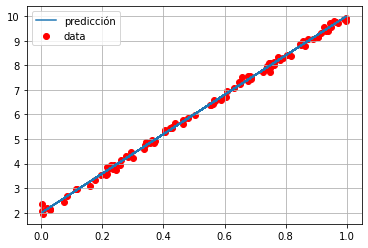

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(X, y_hat, label="predicción")
ax.scatter(X, y, color="r", label="data")
ax.grid()
ax.legend()

fig.show()